In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/UFMG/Mineração de Dados/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download andrewmvd/fetal-health-classification
! unzip fetal-health-classification.zip

# **Trabalho Prático 3 - Mineração de dados**

**Professor:** Wagner Meira Jr.

**Aluna:** Helena Pato Magalhães

**Matrícula:** 2017095723

**Tema:** Classificação de saúde fetal

**Base de dados:** [Fetal Health Classification](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

## Entendimento dos Dados

Importando dados

In [5]:
fetal_health = pd.read_csv('fetal_health.csv')
fetal_health

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


**Colunas**

`baseline value`
Baseline Fetal Heart Rate (FHR)

`accelerations`
Number of accelerations per second

`fetal_movement`
Number of fetal movements per second

`uterine_contractions`
Number of uterine contractions per second

`light_decelerations`
Number of LDs per second

`severe_decelerations`
Number of SDs per second

`prolongued_decelerations`
Number of PDs per second

`abnormal_short_term_variability`
Percentage of time with abnormal short term variability

`mean_value_of_short_term_variability`
Mean value of short term variability

`percentage_of_time_with_abnormal_long_term_variability`
Percentage of time with abnormal long term variability

`mean_value_of_long_term_variability`
Mean value of long term variability

`histogram_width`
Width of the histogram made using all values from a record

`histogram_min`
Histogram minimum value

`histogram_max`
Histogram maximum value

`histogram_number_of_peaks`
Number of peaks in the exam histogram

`histogram_number_of_zeroes`
Number of zeroes in the exam histogram

`histogram_mode`
Hist mode

`histogram_mean`
Hist mean

`histogram_median`
Hist Median

`histogram_variance`
Hist variance

`histogram_tendency`
Histogram trend

`fetal_health`
Fetal health: 1 - Normal 2 - Suspect 3 - Pathological

In [6]:
fetal_health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

Características dos dados

In [7]:
fetal_health[['baseline value',
 'accelerations',
 'fetal_movement',
 'uterine_contractions',
 'light_decelerations',
 'severe_decelerations',
 'prolongued_decelerations',
 'abnormal_short_term_variability',
 'mean_value_of_short_term_variability',
 'percentage_of_time_with_abnormal_long_term_variability',
 'mean_value_of_long_term_variability']].describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000


In [8]:
fetal_health[['histogram_width',
 'histogram_min',
 'histogram_max',
 'histogram_number_of_peaks',
 'histogram_number_of_zeroes',
 'histogram_mode',
 'histogram_mean',
 'histogram_median',
 'histogram_variance',
 'histogram_tendency',
 'fetal_health']].describe()

,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


Distribuição dos dados

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feac481dc90>,
      dtype=object)

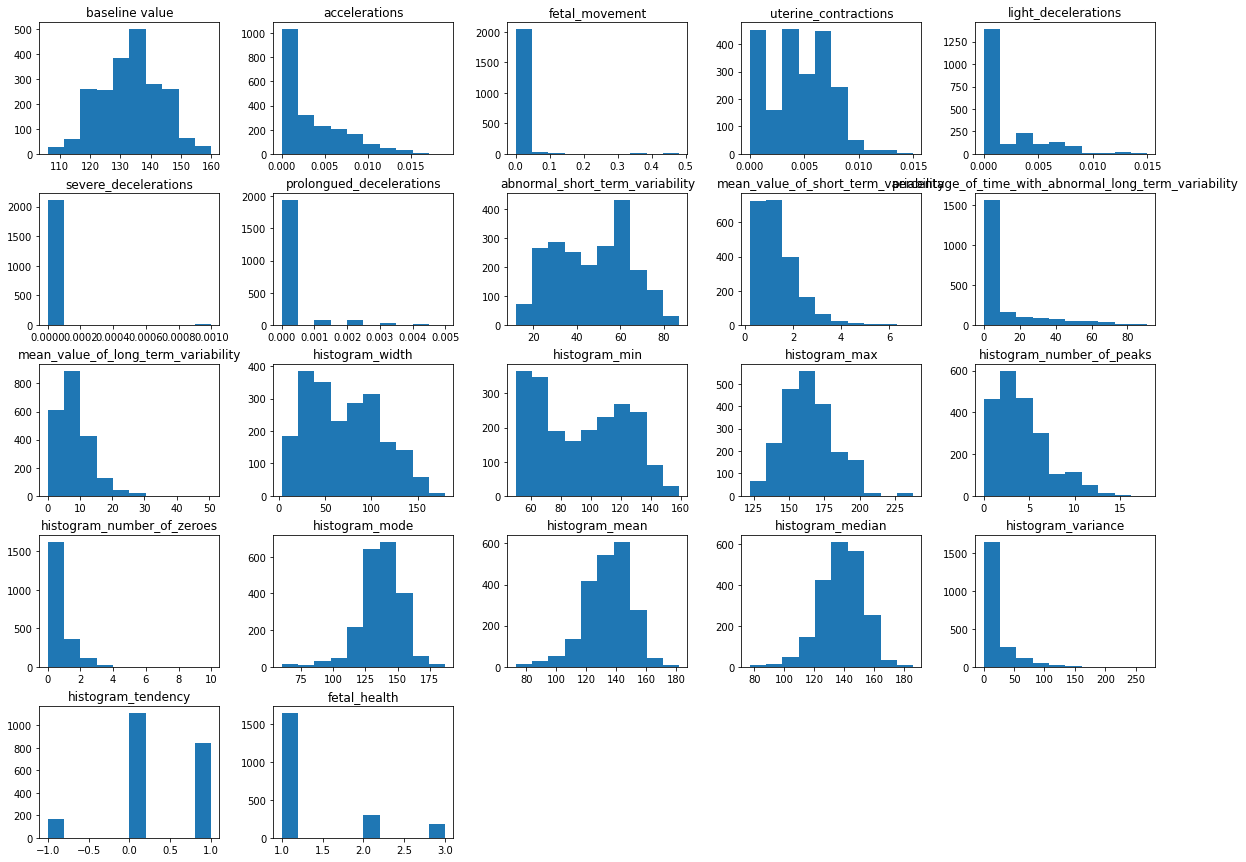

In [9]:
fetal_health.hist(figsize=(20,15), grid=False)

Correlação entre os dados

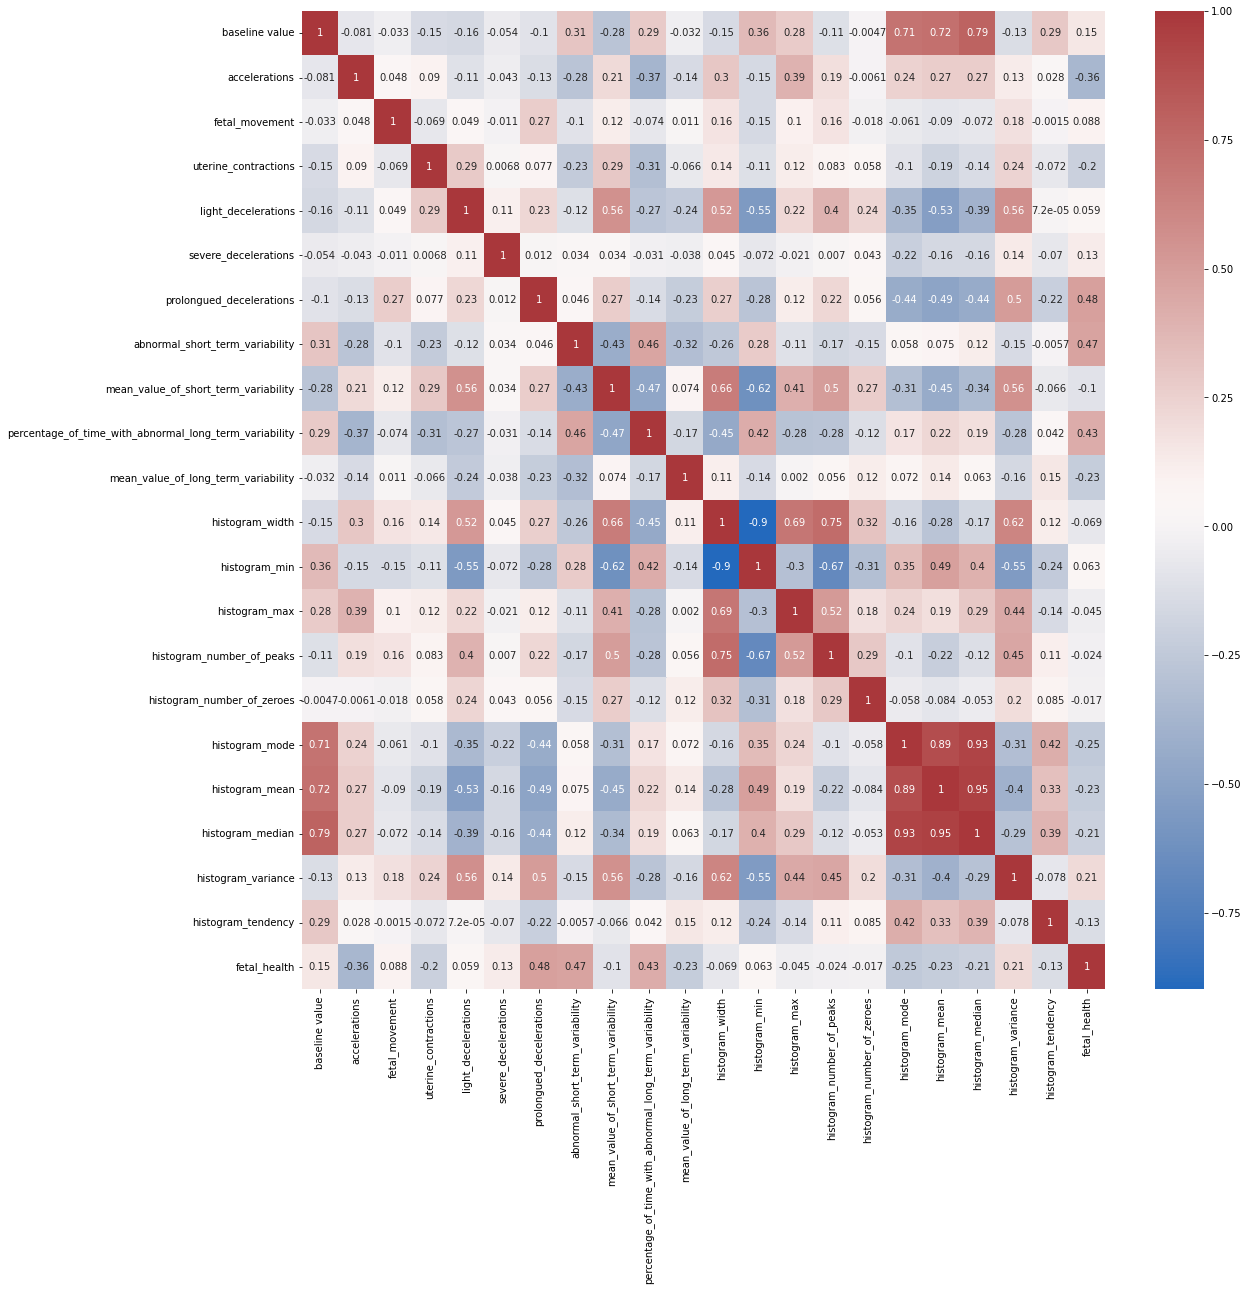

In [10]:
plt.subplots(figsize = (18, 18))
sns.heatmap(fetal_health.corr(), annot = True, cmap='vlag')

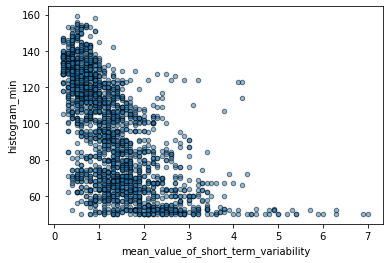

In [11]:
fetal_health.plot.scatter(x='mean_value_of_short_term_variability', y='histogram_min', alpha=0.5, edgecolor='k')

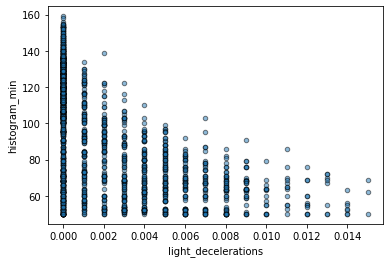

In [12]:
fetal_health.plot.scatter(x='light_decelerations', y='histogram_min', alpha=0.5, edgecolor='k')

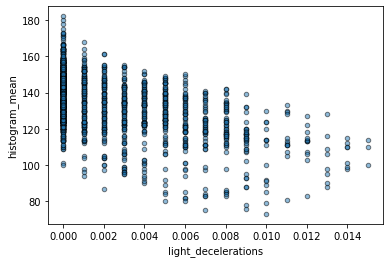

In [13]:
fetal_health.plot.scatter(x='light_decelerations', y='histogram_mean', alpha=0.5, edgecolor='k')

## Preparação dos Dados

Remove os rótulos e converte em array

In [14]:
fetal_health = pd.read_csv('fetal_health.csv')
y = fetal_health.pop('fetal_health')
fetal_health_array = np.array(fetal_health)
fetal_health_array.shape

(2126, 21)

Escala/normaliza os dados

[`sklearn.preprocessing.RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler)

In [15]:
scaler = RobustScaler()
scaler.fit(fetal_health_array)
X = scaler.transform(fetal_health_array)

Redução de dimensionalidade

[`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [16]:
pca = PCA(n_components=0.99, svd_solver='full', random_state=0)
pca.fit(X)
X = pca.transform(X)
pca.components_.shape # (n_components, n_features)

(7, 21)

Lidando com dados desbalanceados

In [17]:
Counter(y)

Counter({2.0: 295, 1.0: 1655, 3.0: 176})

Oversampling

[`imblearn.over_sampling.SMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE)

In [18]:
smote = SMOTE(random_state=0)

X_over, y_over = smote.fit_resample(X, y)
Counter(y_over)

Counter({2.0: 1655, 1.0: 1655, 3.0: 1655})

Undersampling

[`imblearn.under_sampling.ClusterCentroids`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.ClusterCentroids.html#imblearn.under_sampling.ClusterCentroids)

In [19]:
cc = ClusterCentroids(random_state=0)
X_und, y_und = cc.fit_resample(X, y)
Counter(y_und)

Counter({1.0: 176, 2.0: 176, 3.0: 176})

Dividindo em treino, validação e teste

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, test_size=0.2, random_state=0)
X_over_valid, X_over_test, y_over_valid, y_over_test = train_test_split(X_over_test, y_over_test, test_size=0.5, random_state=0)

X_und_train, X_und_test, y_und_train, y_und_test = train_test_split(X_und, y_und, test_size=0.2, random_state=0)
X_und_valid, X_und_test, y_und_valid, y_und_test = train_test_split(X_und_test, y_und_test, test_size=0.5, random_state=0)

In [21]:
print(Counter(y_train))
print(Counter(y_over_train))
print(Counter(y_und_train))

Counter({1.0: 1329, 2.0: 237, 3.0: 134})
Counter({2.0: 1339, 1.0: 1322, 3.0: 1311})
Counter({2.0: 143, 1.0: 140, 3.0: 139})


## Modelagem



Treinando e avaliando um classificador de árvore de decisão

[`sklearn.tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [22]:
def decision_tree(X_train, y_train, X_valid, y_valid):
  tree = DecisionTreeClassifier(criterion='entropy', random_state=0)
  tree.fit(X_train, y_train)

  print('Tree depth:', tree.get_depth())

  y_pred_train = tree.predict(X_train)
  print('\nTrain accuracy:', accuracy_score(y_train, y_pred_train))

  y_pred_valid = tree.predict(X_valid)
  print('Validation accuracy:', accuracy_score(y_valid, y_pred_valid))

  print('Cross validation mean accuracy:', (cross_val_score(tree, X_valid, y_valid, cv=5)).mean())

  print('\nConfusion matrix')
  ConfusionMatrixDisplay.from_estimator(tree, X_valid, y_valid, normalize='true', cmap=plt.cm.Blues)
  plt.show()

  print('\nPrecision:', precision_score(y_valid, y_pred_valid, average='weighted'))
  print('Recall:', recall_score(y_valid, y_pred_valid, average='weighted'))
  print('F1:', f1_score(y_valid, y_pred_valid, average='weighted'))

Dados originais

Tree depth: 21

Train accuracy: 0.9988235294117647
Validation accuracy: 0.8356807511737089
Cross validation mean accuracy: 0.7507198228128461

Confusion matrix


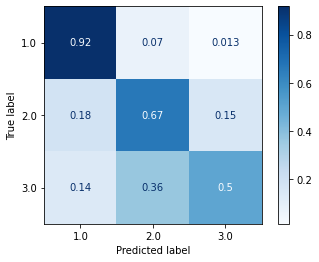


Precision: 0.8446854238678355
Recall: 0.8356807511737089
F1: 0.8384065538995118


In [23]:
decision_tree(X_train, y_train, X_valid, y_valid)

Oversampling

Tree depth: 18

Train accuracy: 0.9997482376636455
Validation accuracy: 0.8951612903225806
Cross validation mean accuracy: 0.8287474747474747

Confusion matrix


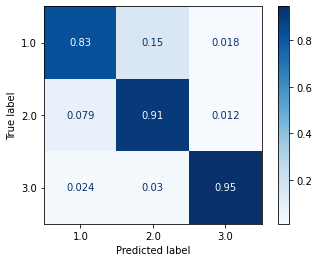


Precision: 0.8975045514024008
Recall: 0.8951612903225806
F1: 0.8953972438446393


In [24]:
decision_tree(X_over_train, y_over_train, X_over_valid, y_over_valid)

Undersampling

Tree depth: 13

Train accuracy: 1.0
Validation accuracy: 0.7547169811320755
Cross validation mean accuracy: 0.7581818181818182

Confusion matrix


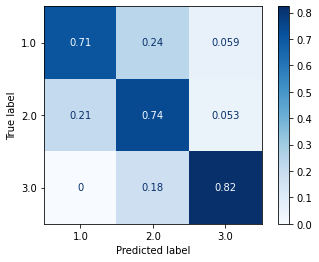


Precision: 0.7602201257861635
Recall: 0.7547169811320755
F1: 0.7563750714694111


In [25]:
decision_tree(X_und_train, y_und_train, X_und_valid, y_und_valid)

Treinando e avaliando um classificador de floresta aleatória

In [26]:
def random_forest(X_train, y_train, X_valid, y_valid):
  rf = RandomForestClassifier(n_estimators=50, max_depth=2, criterion='entropy', random_state=0)
  rf.fit(X_train, y_train)

  y_pred_train = rf.predict(X_train)
  print('Train accuracy:', accuracy_score(y_train, y_pred_train))

  y_pred_valid = rf.predict(X_valid)
  print('Validation accuracy:', accuracy_score(y_valid, y_pred_valid))

  print('Cross validation mean accuracy:', (cross_val_score(rf, X_valid, y_valid, cv=5)).mean())

  print('\nConfusion matrix')
  ConfusionMatrixDisplay.from_estimator(rf, X_valid, y_valid, normalize='true', cmap=plt.cm.Blues)
  plt.show()

  print('\nPrecision:', precision_score(y_valid, y_pred_valid, average='weighted'))
  print('Recall:', recall_score(y_valid, y_pred_valid, average='weighted'))
  print('F1:', f1_score(y_valid, y_pred_valid, average='weighted'))

Dados originais

Train accuracy: 0.8117647058823529
Validation accuracy: 0.7511737089201878
Cross validation mean accuracy: 0.7604651162790698

Confusion matrix


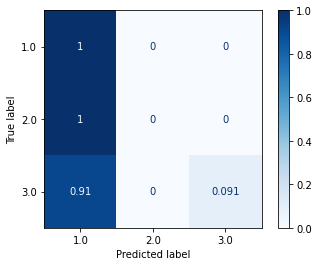


Precision: 0.6587455221057784
Recall: 0.7511737089201878
F1: 0.6524549283051515


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
random_forest(X_train, y_train, X_valid, y_valid)

Oversampling

Train accuracy: 0.8003524672708963
Validation accuracy: 0.8064516129032258
Cross validation mean accuracy: 0.8045454545454545

Confusion matrix


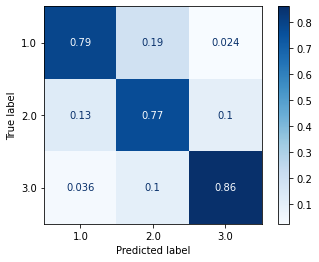


Precision: 0.8086914584748742
Recall: 0.8064516129032258
F1: 0.807179810914548


In [28]:
random_forest(X_over_train, y_over_train, X_over_valid, y_over_valid)

Undersampling

Train accuracy: 0.7819905213270142
Validation accuracy: 0.7735849056603774
Cross validation mean accuracy: 0.7163636363636364

Confusion matrix


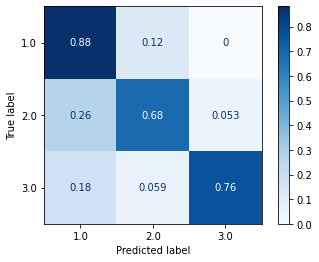


Precision: 0.7983051095745928
Recall: 0.7735849056603774
F1: 0.7758934005738632


In [29]:
random_forest(X_und_train, y_und_train, X_und_valid, y_und_valid)

## Avaliação

Escolhido o melhor modelo (árvore de decisão com oversampling) usamos as mesmas métricas nos dados de teste correspondentes

Tree depth: 18

Train accuracy: 0.9997482376636455
Validation accuracy: 0.9235412474849095
Cross validation mean accuracy: 0.8211515151515151

Confusion matrix


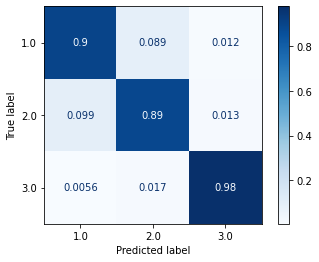


Precision: 0.9235867458136782
Recall: 0.9235412474849095
F1: 0.9235583542137511


In [30]:
decision_tree(X_over_train, y_over_train, X_over_test, y_over_test)

Testamos também nos dados originais de teste

Tree depth: 18

Train accuracy: 0.9997482376636455
Validation accuracy: 0.9859154929577465
Cross validation mean accuracy: 0.8593576965669989

Confusion matrix


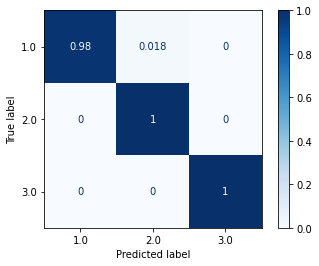


Precision: 0.9874245472837023
Recall: 0.9859154929577465
F1: 0.9862506673561682


In [31]:
decision_tree(X_over_train, y_over_train, X_test, y_test)